# Proyecto: Análisis estadístico

# Tema: Análisis de Series de Tiempo

 # Modelo - Análisis de movimientos en acciones de Tatamotors

# Tatamotors
![](./imgs/Tata-Motors.jpg)

# ETL

In [1]:
import pandas as pd
import numpy as np
import plotly.express as px

In [2]:
# https://in.finance.yahoo.com/quote/TATAMOTORS.NS/history?p=TATAMOTORS.NS
data = pd.read_csv('./datasets/tatamotors.csv')
data.head()


,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-06-28,448.000000,448.000000,433.000000,440.399994,440.221710,10190394.0
1,2016-06-29,447.100006,449.799988,445.399994,447.250000,447.068939,6285461.0
2,2016-06-30,454.299988,462.250000,451.549988,459.250000,459.064087,13214064.0
3,2016-07-01,463.600006,464.750000,454.700012,457.899994,457.714630,7027759.0
4,2016-07-04,467.000000,474.850006,467.000000,469.500000,469.309937,8413087.0


In [3]:
data['Date'] = pd.to_datetime(data['Date'])
data['Year'] = data['Date'].dt.year
data['Month'] = data['Date'].dt.month
data['Day'] = data['Date'].dt.day


In [4]:
data.rename(columns={'Adj Close': 'Price'}, inplace=True)
data.head()


,Date,Open,High,Low,Close,Price,Volume,Year,Month,Day
0,2016-06-28,448.000000,448.000000,433.000000,440.399994,440.221710,10190394.0,2016,6,28
1,2016-06-29,447.100006,449.799988,445.399994,447.250000,447.068939,6285461.0,2016,6,29
2,2016-06-30,454.299988,462.250000,451.549988,459.250000,459.064087,13214064.0,2016,6,30
3,2016-07-01,463.600006,464.750000,454.700012,457.899994,457.714630,7027759.0,2016,7,1
4,2016-07-04,467.000000,474.850006,467.000000,469.500000,469.309937,8413087.0,2016,7,4


In [5]:
# selecting data to work
data_temp = data.loc[data['Year'] > 2014, ['Date', 'Price']]
data_temp.shape


(1233, 2)

In [6]:
data_temp['Date'].min(), data_temp['Date'].max()


(Timestamp('2016-06-28 00:00:00'), Timestamp('2021-06-25 00:00:00'))

In [7]:
data_grp = data_temp.groupby(['Date'], as_index=True).mean()
data_grp.head(5)


,Price
Date,
2016-06-28,440.221710
2016-06-29,447.068939
2016-06-30,459.064087
2016-07-01,457.714630
2016-07-04,469.309937


In [8]:
df_indx = data_grp.Price.resample('MS').mean()
df_indx.head(10)

df = df_indx.reset_index()
df.head(10)


,Date,Price
0,2016-06-01,448.784912
1,2016-07-01,487.719057
2,2016-08-01,508.381818
3,2016-09-01,553.997504
4,2016-10-01,548.713884
5,2016-11-01,486.659526
6,2016-12-01,461.181818
7,2017-01-01,517.695240
8,2017-02-01,486.223678
9,2017-03-01,468.318182


<AxesSubplot:xlabel='Date'>

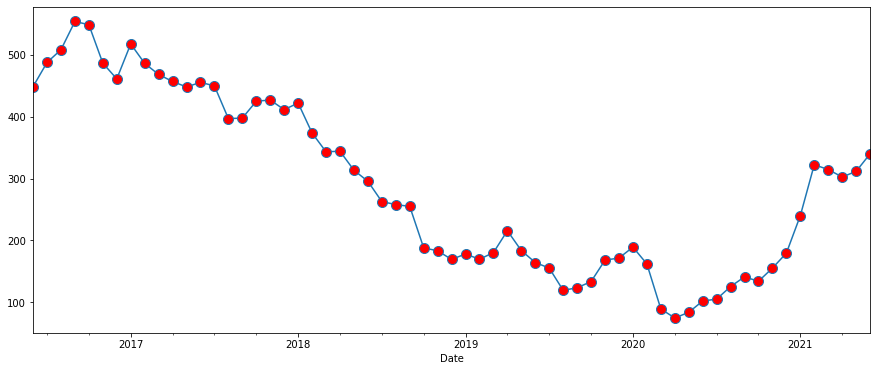

In [9]:
import matplotlib.pyplot as plt
fig = plt.figure(facecolor='w')
df_indx.plot(figsize=(15, 6), marker="o", markersize=10, markerfacecolor='red')


# Tatamotors share price tendency

In [10]:
fig = px.line(data, x='Date', y='Price', title='Tatamotors share price(2016-2021)')
fig.show()

In [11]:
fig = px.box(data, x='Year', y='Price', title='tatamotos share price (2016-2021)')
fig.show()

# Estacionalidad

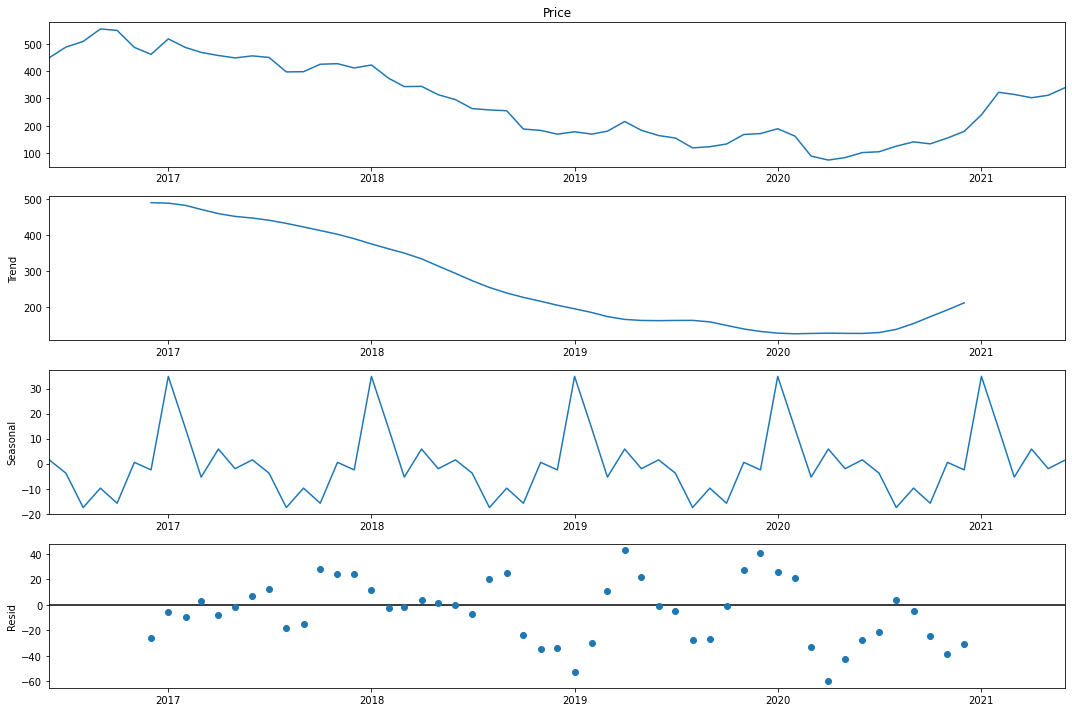

In [12]:
import statsmodels.api as sm
matplotlib.rcParams['figure.figsize']=15,10
decomposition = sm.tsa.seasonal_decompose(df_indx, model = 'additive')
fig = decomposition.plot()
plt.show()


In [13]:
from statsmodels.tsa.stattools import adfuller
print('Los datos son estacionarios?')
df_test = adfuller(df.Price, autolag = None)
print(f'Prueba estadistica{df_test[0]}')
print(f'P-value={df_test[1]}')
print(f'Valores criticos:')
for k, v in df_test[4].items():
    print('\t{}:{} Los datos {} son estacionarios con {}% de confianza'.format(k, v, "no" if v < df_test[0] else "", 100-int(k[:-1])))
    

Los datos son estacionarios?
Prueba estadistica-1.3325422946520702
P-value=0.6141558381345494
Valores criticos:
	1%:-3.5714715250448363 Los datos no son estacionarios con 99% de confianza
	5%:-2.922629480573571 Los datos no son estacionarios con 95% de confianza
	10%:-2.5993358475635153 Los datos no son estacionarios con 90% de confianza


# Valores PDQ propuestos por intertools para Sarimax

In [14]:
import itertools 
p = d = q = range(0,2)
# AIC(Arkaike Information Criteria)
# Este estimador nos permite encontrar los mejores parámetros para Sarimax
pdq = list(itertools.product(p,d,q))
seasonal_pdq = [(x[0],x[1],x[2],12) for x in list( itertools.product(p,d,q))]
print(f'Sarimax: {pdq[1]} x {seasonal_pdq[1]}')

Sarimax: (0, 0, 1) x (0, 0, 1, 12)


In [15]:
for param in pdq:
  for param_estacional in seasonal_pdq:
    try:
      mod= sm.tsa.statespace.SARIMAX(
          df_indx,
          order=param,
          seasonal_order=param_estacional,
          enforce_stationarity = False
      )
      results = mod.fit()
      print(f'ARIMA {param} x {param_estacional}12 - AIC:{results.aic}')
    except:
      continue
  

ARIMA (0, 0, 0) x (0, 0, 0, 12)12 - AIC:863.9733593376744
ARIMA (0, 0, 0) x (0, 0, 1, 12)12 - AIC:648.9133292781726
ARIMA (0, 0, 0) x (0, 1, 0, 12)12 - AIC:611.3598561923671


C:\Users\lgutierrez\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.



ARIMA (0, 0, 0) x (0, 1, 1, 12)12 - AIC:458.50880813524674
ARIMA (0, 0, 0) x (1, 0, 0, 12)12 - AIC:593.6489170617295
ARIMA (0, 0, 0) x (1, 0, 1, 12)12 - AIC:572.0188780119095
ARIMA (0, 0, 0) x (1, 1, 0, 12)12 - AIC:472.84869006405586
ARIMA (0, 0, 0) x (1, 1, 1, 12)12 - AIC:459.9051322178443
ARIMA (0, 0, 1) x (0, 0, 0, 12)12 - AIC:775.5478939538103
ARIMA (0, 0, 1) x (0, 0, 1, 12)12 - AIC:577.294605303615
ARIMA (0, 0, 1) x (0, 1, 0, 12)12 - AIC:545.716003339802


C:\Users\lgutierrez\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



ARIMA (0, 0, 1) x (0, 1, 1, 12)12 - AIC:406.4093201075629
ARIMA (0, 0, 1) x (1, 0, 0, 12)12 - AIC:541.6020820182669


C:\Users\lgutierrez\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA (0, 0, 1) x (1, 0, 1, 12)12 - AIC:513.0641528731634
ARIMA (0, 0, 1) x (1, 1, 0, 12)12 - AIC:432.832121709588
ARIMA (0, 0, 1) x (1, 1, 1, 12)12 - AIC:407.9655931312868
ARIMA (0, 1, 0) x (0, 0, 0, 12)12 - AIC:569.5143222418415
ARIMA (0, 1, 0) x (0, 0, 1, 12)12 - AIC:454.5648736242788
ARIMA (0, 1, 0) x (0, 1, 0, 12)12 - AIC:483.757532402716
ARIMA (0, 1, 0) x (0, 1, 1, 12)12 - AIC:352.57205066999865
ARIMA (0, 1, 0) x (1, 0, 0, 12)12 - AIC:463.24490094599
ARIMA (0, 1, 0) x (1, 0, 1, 12)12 - AIC:456.29246606767674
ARIMA (0, 1, 0) x (1, 1, 0, 12)12 - AIC:361.9678356440545
ARIMA (0, 1, 0) x (1, 1, 1, 12)12 - AIC:352.64973230947004
ARIMA (0, 1, 1) x (0, 0, 0, 12)12 - AIC:557.1004012640204
ARIMA (0, 1, 1) x (0, 0, 1, 12)12 - AIC:438.7368949871414
ARIMA (0, 1, 1) x (0, 1, 0, 12)12 - AIC:456.14151588151225
ARIMA (0, 1, 1) x (0, 1, 1, 12)12 - AIC:335.87076204640397
ARIMA (0, 1, 1) x (1, 0, 0, 12)12 - AIC:457.0672035448848
ARIMA (0, 1, 1) x (1, 0, 1, 12)12 - AIC:437.2676694676941
ARIMA (0, 1, 

C:\Users\lgutierrez\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA (1, 0, 0) x (0, 1, 0, 12)12 - AIC:496.11881906291825
ARIMA (1, 0, 0) x (0, 1, 1, 12)12 - AIC:364.45954189074536
ARIMA (1, 0, 0) x (1, 0, 0, 12)12 - AIC:463.559034212709
ARIMA (1, 0, 0) x (1, 0, 1, 12)12 - AIC:465.3343188614682
ARIMA (1, 0, 0) x (1, 1, 0, 12)12 - AIC:363.848199781377
ARIMA (1, 0, 0) x (1, 1, 1, 12)12 - AIC:364.7473847647215
ARIMA (1, 0, 1) x (0, 0, 0, 12)12 - AIC:567.0791567973487
ARIMA (1, 0, 1) x (0, 0, 1, 12)12 - AIC:451.1985849769264
ARIMA (1, 0, 1) x (0, 1, 0, 12)12 - AIC:468.7091817427792
ARIMA (1, 0, 1) x (0, 1, 1, 12)12 - AIC:347.16172473861013
ARIMA (1, 0, 1) x (1, 0, 0, 12)12 - AIC:458.4203233309351
ARIMA (1, 0, 1) x (1, 0, 1, 12)12 - AIC:451.2753763261558
ARIMA (1, 0, 1) x (1, 1, 0, 12)12 - AIC:356.32938179059397
ARIMA (1, 0, 1) x (1, 1, 1, 12)12 - AIC:346.5568577202786
ARIMA (1, 1, 0) x (0, 0, 0, 12)12 - AIC:567.3173021508588
ARIMA (1, 1, 0) x (0, 0, 1, 12)12 - AIC:451.45666750503136
ARIMA (1, 1, 0) x (0, 1, 0, 12)12 - AIC:475.7383251612462
ARIMA (1, 1

In [16]:
mod= sm.tsa.statespace.SARIMAX(
          df_indx,
          order=(0, 0, 1),
          seasonal_order=(0, 0, 1, 12),
          enforce_stationarity = False
      )
resultados = mod.fit()

# Resualtados

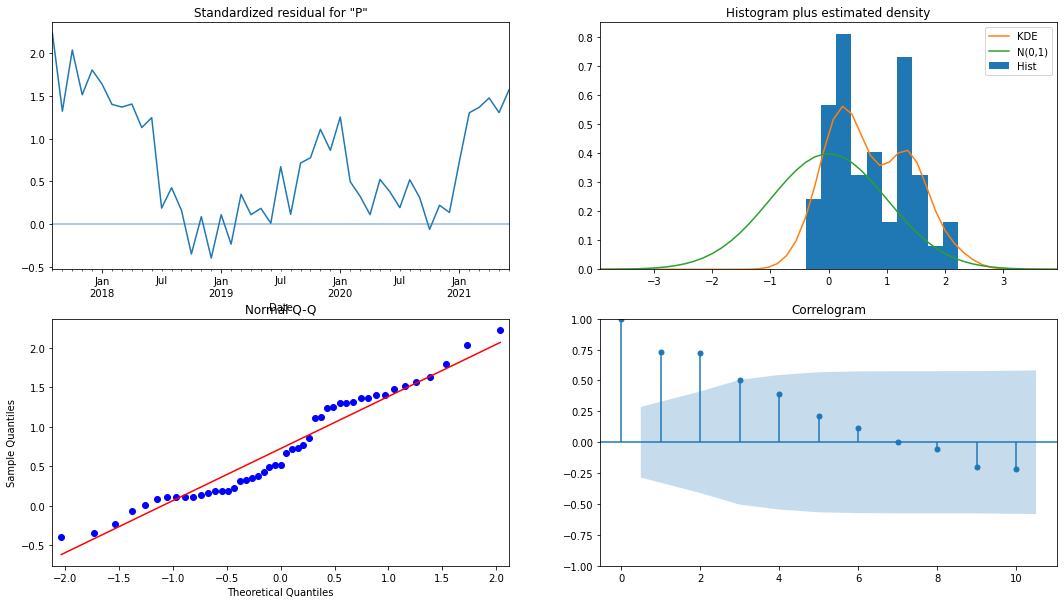

In [17]:
resultados.plot_diagnostics(figsize=(18,10))
plt.show()

# Predicciones

In [18]:
predicciones = resultados.get_prediction(start=pd.to_datetime('2019-01-01'))
pred_conf_int = predicciones.conf_int()
pred_conf_int


,lower Price,upper Price
Date,,
2019-01-01,-40.533457,373.185241
2019-02-01,-12.652694,400.954192
2019-03-01,-63.162857,350.337270
2019-04-01,-2.752560,410.645526
2019-05-01,-42.540125,370.760447
2019-06-01,-43.587251,369.649961
2019-07-01,-108.869534,284.840819
2019-08-01,-88.887813,304.478475
2019-09-01,-144.548056,248.527489


# Valores observados vs Predicciones

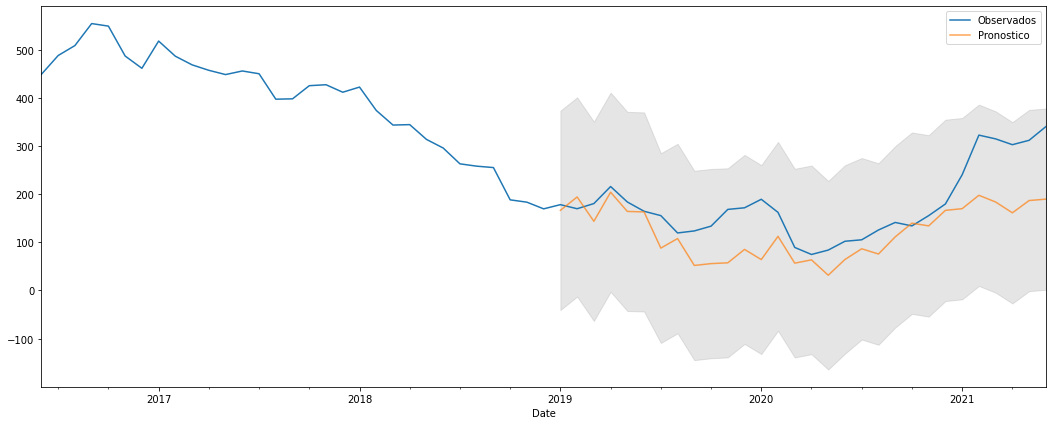

In [19]:
ax = df_indx['2016':].plot(label='Observados')
predicciones.predicted_mean.plot(ax=ax, label ='Pronostico', alpha =.7, figsize=(18,7))
ax.fill_between(pred_conf_int.index,
                pred_conf_int.iloc[:,0],
                pred_conf_int.iloc[:,1],
                color='gray',
                alpha=.2)
plt.legend()
plt.show()


# Valores pronosticados a futuro

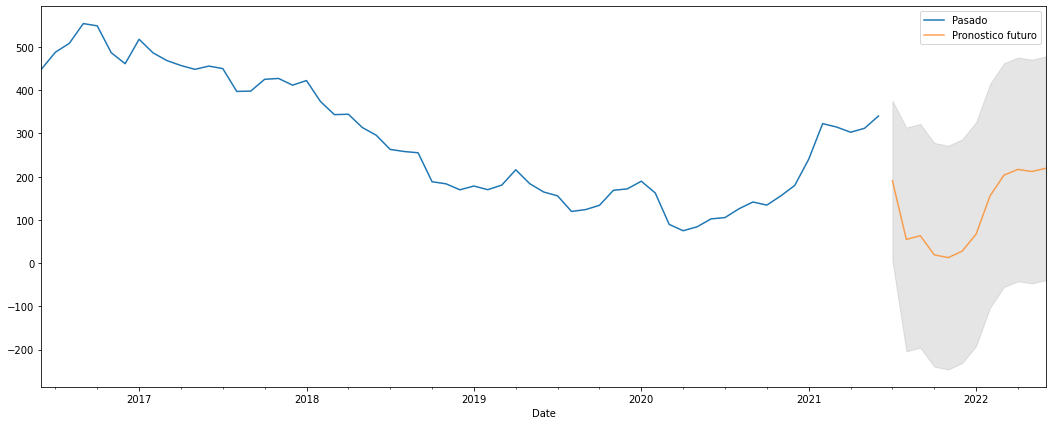

In [20]:
prediccion_futurista = resultados.get_forecast(steps=12)
pred_ci=prediccion_futurista.conf_int()
ax = df_indx.plot(label='Pasado')
prediccion_futurista.predicted_mean.plot(ax=ax, label ='Pronostico futuro', alpha =.7, figsize=(18,7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:,0],
                pred_ci.iloc[:,1],
                color='gray',
                alpha=.2)
plt.legend()
plt.show()

# Es cuanto...
![](./imgs/autobus.jpg)